### Essential libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from typing import List
from imblearn.over_sampling import SMOTE

In [2]:
file_path = '/content/diabetes.csv'
data = pd.read_csv(file_path)

### Data preprocessing

In [4]:
data = data[data['BMI'] != 0]
data = data[data['Glucose'] != 0]
# Separate features and labels
X = data.drop(columns=['Outcome'])
y = data['Outcome'].values

# Identify outliers using IQR and replace with median
def replace_outliers_with_median(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = df[column].median()
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), median_value, df[column])

# Replace outliers in Insulin and SkinThickness columns
replace_outliers_with_median(X, 'Insulin')
replace_outliers_with_median(X, 'SkinThickness')

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Convert data to tensor
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.float32).view(-1, 1)

# Split the dataset into training, validation, and test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:
class FeatureNN(nn.Module):
    def __init__(self, input_shape, num_units, dropout, hidden_sizes, activation):
        super(FeatureNN, self).__init__()
        layers = []
        input_dim = input_shape
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_dim, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(p=dropout))
            input_dim = hidden_size
        layers.append(nn.Linear(input_dim, num_units))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x.unsqueeze(-1))

class NAMClassifier(nn.Module):
    def __init__(self, num_inputs: int, num_units: List[int], hidden_sizes: List[int], dropout: float, feature_dropout: float, activation: str = 'relu'):
        super(NAMClassifier, self).__init__()
        assert len(num_units) == num_inputs
        self.num_inputs = num_inputs
        self.num_units = num_units
        self.hidden_sizes = hidden_sizes
        self.dropout = dropout
        self.feature_dropout = feature_dropout
        self.activation = activation

        self.dropout_layer = nn.Dropout(p=self.feature_dropout)
        self.feature_nns = nn.ModuleList([
            FeatureNN(input_shape=1, num_units=self.num_units[i], dropout=self.dropout, hidden_sizes=self.hidden_sizes, activation=self.activation)
            for i in range(num_inputs)
        ])
        self._bias = torch.nn.Parameter(data=torch.zeros(1))

    def calc_outputs(self, inputs):
        return [self.feature_nns[i](inputs[:, i]) for i in range(self.num_inputs)]

    def forward(self, inputs):
        individual_outputs = self.calc_outputs(inputs)
        conc_out = torch.cat(individual_outputs, dim=-1)
        dropout_out = self.dropout_layer(conc_out).unsqueeze(1)
        out = torch.sum(dropout_out, dim=-1)
        return out + self._bias

# Initialize the model, loss function, and optimizer
num_inputs = X_tensor.shape[1]
num_units = [64] * num_inputs  # Number of units for each input feature
hidden_sizes = [32, 16]  # Hidden layer sizes
dropout = 0.2
feature_dropout = 0.2

model = NAMClassifier(num_inputs, num_units, hidden_sizes, dropout, feature_dropout)

### Train model

In [6]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.sigmoid(outputs).round()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(correct_train / total_train)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            predicted = torch.sigmoid(outputs).round()
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(correct_val / total_val)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_nam_model.pth')

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_nam_model.pth'))


Epoch [10/50], Train Loss: 0.7289, Val Loss: 0.5056, Train Acc: 0.7072, Val Acc: 0.7010
Epoch [20/50], Train Loss: 0.6610, Val Loss: 0.4958, Train Acc: 0.7218, Val Acc: 0.7320
Epoch [30/50], Train Loss: 0.6308, Val Loss: 0.4914, Train Acc: 0.7365, Val Acc: 0.7113
Epoch [40/50], Train Loss: 0.6095, Val Loss: 0.4567, Train Acc: 0.7467, Val Acc: 0.7216
Epoch [50/50], Train Loss: 0.6198, Val Loss: 0.5139, Train Acc: 0.7218, Val Acc: 0.7113


<All keys matched successfully>

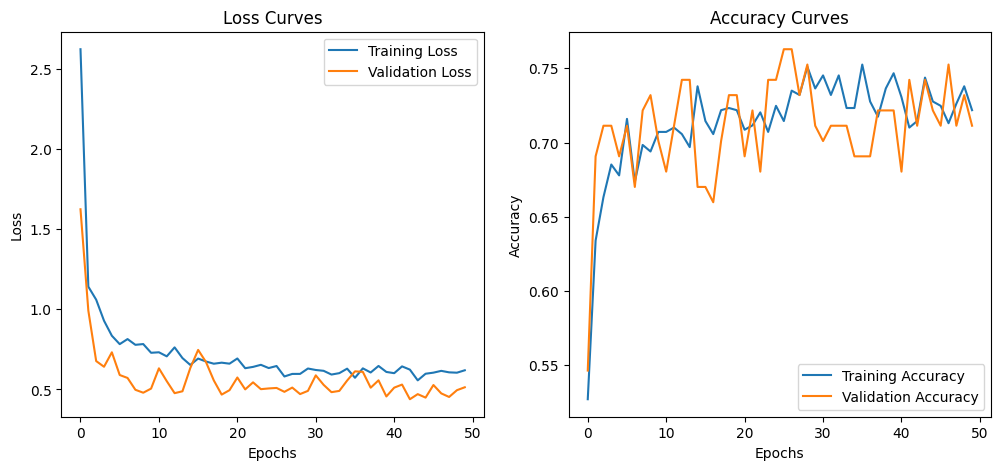

In [7]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

### Evaluate the model

In [8]:
# Evaluate the model on the test set
model.eval()
test_labels = []
test_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.sigmoid(outputs).round()
        test_labels.extend(labels.numpy())
        test_predictions.extend(predictions.numpy())

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)

# Calculate evaluation metrics
test_acc = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
test_conf_matrix = confusion_matrix(test_labels, test_predictions)

# Display evaluation results
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Confusion Matrix:')
print(test_conf_matrix)

Test Accuracy: 0.8112
Test Precision: 0.8182
Test Recall: 0.8411
Test F1 Score: 0.8295
Confusion Matrix:
[[69 20]
 [17 90]]


In [9]:
def calc_feature_outputs(model, feature_index, input_data, num_points=100):
    """
    Calculate the outputs for a specific feature by varying its values and keeping other features fixed.
    """
    x_min, x_max = input_data[:, feature_index].min(), input_data[:, feature_index].max()
    x_values = np.linspace(x_min, x_max, num_points)
    fixed_inputs = np.copy(input_data)

    outputs = []
    for x in x_values:
        fixed_inputs[:, feature_index] = x
        with torch.no_grad():
            fixed_inputs_tensor = torch.tensor(fixed_inputs, dtype=torch.float32)
            output = model(fixed_inputs_tensor)
            outputs.append(torch.sigmoid(output).cpu().numpy())

    return x_values, np.array(outputs)


In [10]:
# Convert test inputs to numpy array for easier manipulation
test_inputs = torch.stack([sample[0] for sample in test_dataset]).numpy()


### Partial Dependence Plot (PDP) and Individual Conditional Expectation (ICE)

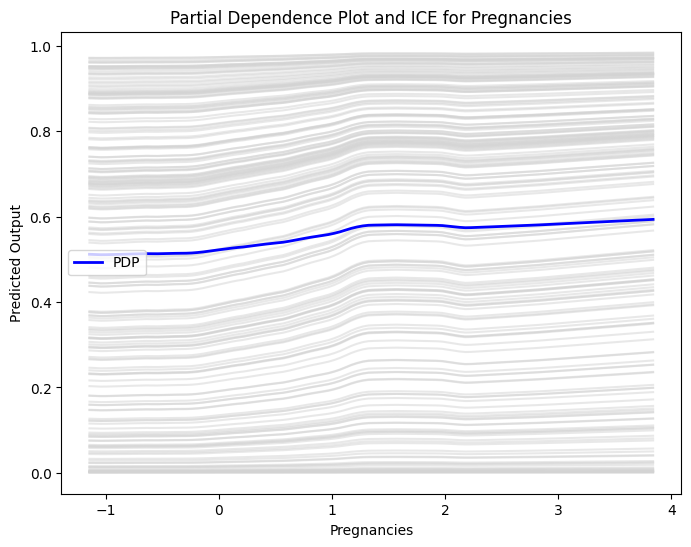

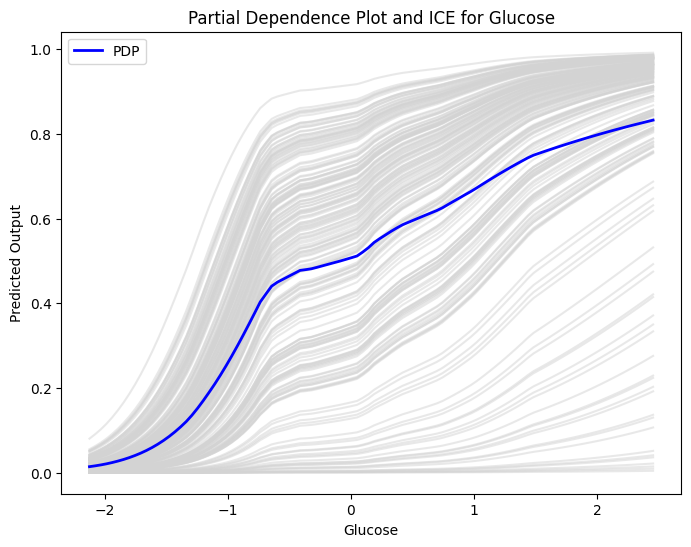

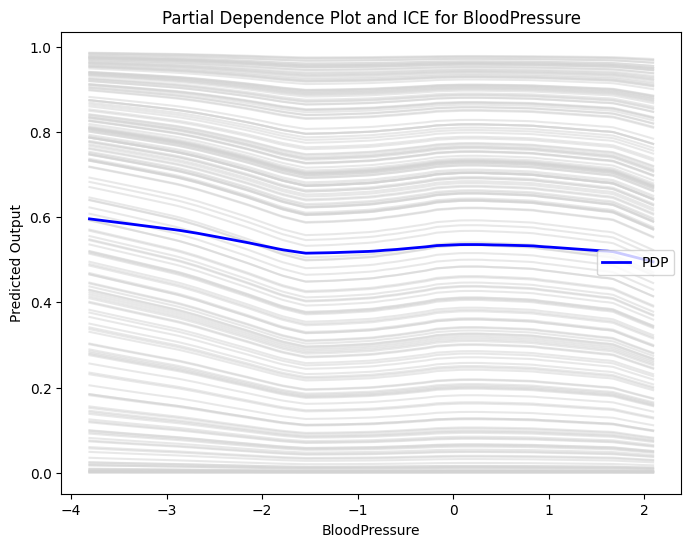

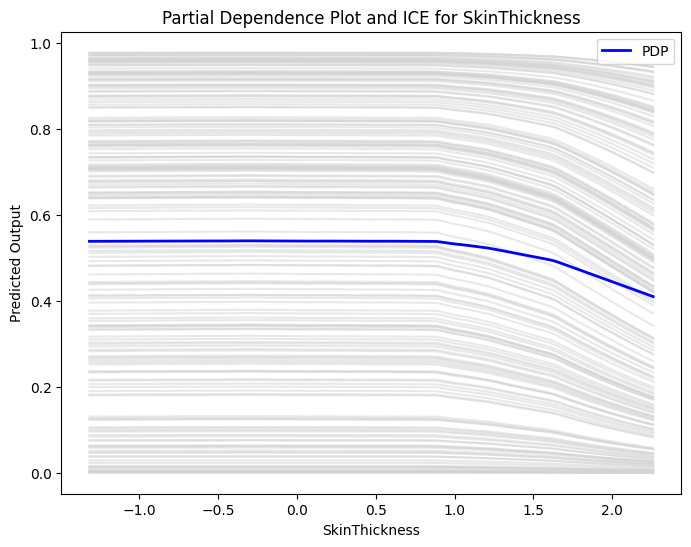

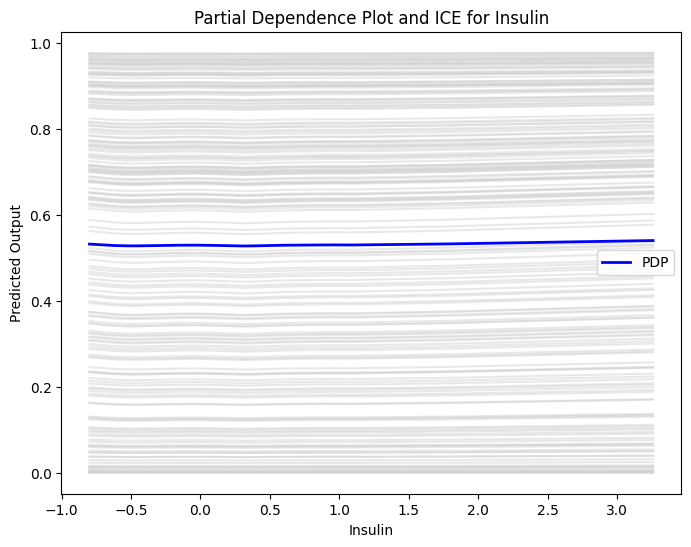

In [11]:
import matplotlib.pyplot as plt

def plot_pdp_ice(model, feature_index, input_data, feature_name, num_points=100):
    x_values, outputs = calc_feature_outputs(model, feature_index, input_data, num_points)

    # Plot ICE curves
    plt.figure(figsize=(8, 6))
    for i in range(outputs.shape[1]):
        plt.plot(x_values, outputs[:, i], color='lightgray', alpha=0.5)

    # Plot PDP curve
    pdp_curve = outputs.mean(axis=1)
    plt.plot(x_values, pdp_curve, color='blue', linewidth=2, label='PDP')

    plt.xlabel(feature_name)
    plt.ylabel('Predicted Output')
    plt.title(f'Partial Dependence Plot and ICE for {feature_name}')
    plt.legend()
    plt.show()

# Feature indices and names (replace with actual indices and names)
feature_indices = [0, 1, 2, 3, 4]  # Adjust based on your dataset
feature_names = data.columns[:-1]  # Adjust based on your dataset

for feature_index in feature_indices:
    plot_pdp_ice(model, feature_index, test_inputs, feature_names[feature_index])
